In [1]:
import torch 
from torch import nn
from torch.utils.data import random_split
import numpy as np
import torch.optim as optim
torch.manual_seed(8)
import matplotlib.pyplot as plt

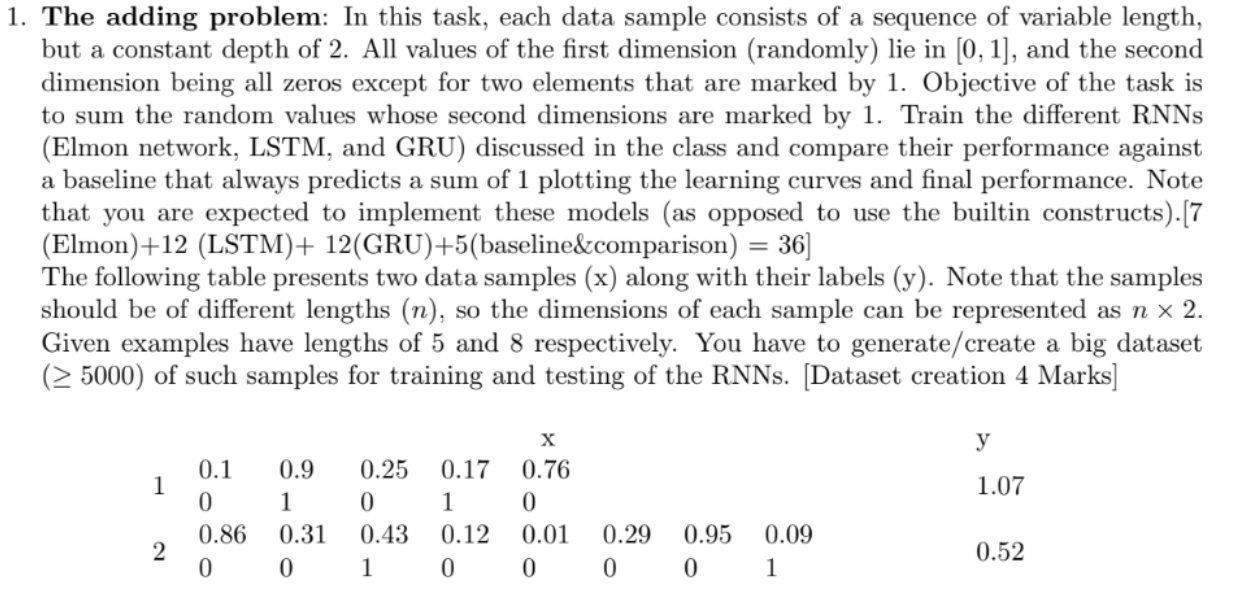

## Function for generating sample data

In [2]:
def generate_sample(low = 2, high = 8):
    """
        Generates a sample of random length between 'low' and 'high', with random values b/w [0, 1] in the 1st dimension
        and with two 1s in the 2nd dimension. 
        The label = sum of the random values whose 2nd dimensions are marked by 1.
    
    Returns :
        x: A 2D array of random length b/w 'low' and 'high'
        y: The sum of the random values whose 2nd dimensions are marked by 1.
                                                                                                                    """
    # n = length of sequence b/w 2 and 10 by default
    n = np.random.randint(low, high)
    
    # x is a 2D vector , 1st dimension contains values b/w 0 and 1 , 2nd dimension alll 0s
    x = np.random.rand(n, 2)
    x[:, 1] = 0
    
    # Choose any 2 indices randomly and make x[indices, 1] = 1
    rand_indices = np.random.choice(n, 2, replace=False)
    x[rand_indices, 1] = 1
    
    y = x[:, 0] * x[:, 1]
    return x, y.sum()


## ElmanNet Class

In [3]:
class ElmanNet(nn.Module):
    def __init__(self, input_size, hidden_size, op_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.op_size = op_size
        
         
        # Initialise the weight (Xavier initialisation) 
        self.W_xh = nn.Parameter(torch.empty(hidden_size, input_size), requires_grad=True)  # 3 x 2  
        self.W_hh = nn.Parameter(torch.empty(hidden_size, hidden_size), requires_grad=True) # 3 x 3
        self.W_hy = nn.Parameter(torch.empty(op_size, hidden_size), requires_grad=True)  # 1 x 3
        nn.init.xavier_normal_(self.W_xh)
        nn.init.xavier_normal_(self.W_hh)
        nn.init.xavier_normal_(self.W_hy)
        
        self.b_h = nn.Parameter(torch.rand(hidden_size, 1), requires_grad=True)               # 3 x 1
        self.b_y = nn.Parameter(torch.rand(op_size, 1), requires_grad=True)                # 1 x 1
        
        
        # Hidden state is initialised as zero
        self.h_t = torch.zeros(hidden_size, 1)
    
    def forward(self, x):
        """ 
        x : numpy 2D array : 1st dimension b/w [0,1] and 2nd dimension having 1 in 2 places
        Returns:
            y : scalar value : predicted value using the Elman network
                                                                                                """        
        H = self.h_t
        for t in range(x.shape[0]):
            H = torch.tanh(torch.matmul(self.W_xh.data ,torch.Tensor(x[t]).unsqueeze(1)) + torch.matmul(self.W_hh.data, H) + self.b_h)

        y = torch.matmul(self.W_hy.data, H) + self.b_y
        
        return y
    
    
    def train(self, datas, n_epochs = 20):
        """ 
            Trains the network {net} for {n_epochs} epochs using the train data {datas} 
            net : A instantiated neural network class
            datas : Train data is a list of tuples where tuples are of the form ({2D array of variable length}, {label})
            n_epochs : Number of epochs to train for.
                                                                                                                        """
        # Define the optimiser and loss function
        optimizer = optim.SGD(self.parameters(), lr=0.05)
        criterion = nn.MSELoss()                         # (Loss fn = MSE)
        
        # Training loop
        baseline_loss = 0
        cumulative_loss_list = []
        for epoch in range(1, n_epochs + 1):
            cumulative_loss = 0
            for data in datas:
                
                # Get inputs and labels
                inputs, labels = data
                
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward + backward prop using the loss defined + optimize using the optimiser defined 
                y_pred = self.forward(inputs)
                loss = criterion(y_pred, torch.tensor([labels]).unsqueeze(1).float())
                if epoch == 1:
                    baseline_loss += criterion(torch.tensor([[1]]), torch.tensor([labels]).unsqueeze(1).float())
                
                # Compute gradients using backward pass
                loss.backward()
                
                # Update the parameters using the gradients and Adam optimiser
                optimizer.step()

                # Update running loss
                cumulative_loss += loss.item()

            
            cumulative_loss = cumulative_loss/(epoch*len(datas))
            cumulative_loss_list.append(cumulative_loss)
            print(f"Epoch {epoch}, Epoch_loss {cumulative_loss}. ")

    
        plt.plot(cumulative_loss_list, label='RNN loss')
        plt.xlabel('Epochs')
        plt.ylabel('MSE running Loss')
        plt.axhline(y=baseline_loss/len(datas), color='r', ls='--', label='Baseline loss')
        plt.legend()
        print(f"Baseline loss {baseline_loss/len(datas)}")
        
        return cumulative_loss_list
        
                


### Training for Elman Net

Epoch 1, Epoch_loss 0.17755229089592442. 
Epoch 2, Epoch_loss 0.07251080749298641. 
Epoch 3, Epoch_loss 0.048131175521336236. 
Epoch 4, Epoch_loss 0.03603670165475794. 
Epoch 5, Epoch_loss 0.02880015113194523. 
Epoch 6, Epoch_loss 0.02398313557892898. 
Epoch 7, Epoch_loss 0.020545890532825604. 
Epoch 8, Epoch_loss 0.017969896981818653. 
Epoch 9, Epoch_loss 0.015967550375224366. 
Epoch 10, Epoch_loss 0.014366476970131456. 
Baseline loss 0.16186334192752838


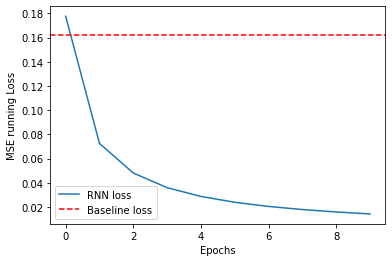

In [4]:
# Define hyperparameters
input_size = 2
output_size = 1
n_epochs = 10
hidden_sizes = [8]

# n_samples to generate
n_samples = 5000
datas = [generate_sample() for _ in range(n_samples)]      # datas is a LIST


# Split dataset into train and validation sets 
train_size = int(0.8 * len(datas))
val_size = len(datas) - train_size
train_datas, val_datas = random_split(datas, [train_size, val_size], generator=torch.Generator().manual_seed(2)) 

for hidden_size in hidden_sizes:
    # Instantiate model and optimizer
    net = ElmanNet(input_size, hidden_size, output_size)
    RNN_loss_list = net.train(train_datas, n_epochs)

### Testing for Elman Net

In [5]:
Rnn_cumulative_loss = 0
with torch.no_grad():
     for data in val_datas:

        # Get inputs and labels
        inputs, labels = data

        # Forward + backward prop using the loss defined + optimize using the optimiser defined 
        y_pred = net.forward(inputs)
        criterion = nn.MSELoss()
        loss = criterion(y_pred, torch.tensor([labels]).unsqueeze(1).float())

        # Update running loss
        Rnn_cumulative_loss += loss.item()


Rnn_cumulative_loss = Rnn_cumulative_loss/(len(datas))
print(f" Test_loss {Rnn_cumulative_loss}. ")

 Test_loss 0.02633606344889165. 


## LSTM(Long short term memory) network Class 

In [6]:
class LSTMnet(nn.Module):
    def __init__(self, ip_size, h_size, op_size):
        super().__init__()
        self.ip_size = ip_size
        self.h_size = h_size
        self.op_size = op_size
        
        # (Xavier weigth initialisation) 
         # I/p gate , Hidden state , forget gate, o/p gate weights
        self.W_ch = nn.Parameter(torch.empty(h_size, h_size), requires_grad=True) 
        self.W_cx = nn.Parameter(torch.empty(h_size, ip_size), requires_grad=True) 
        self.W_fh = nn.Parameter(torch.empty(h_size, h_size), requires_grad=True) 
        self.W_fx = nn.Parameter(torch.empty(h_size, ip_size), requires_grad=True) 
        self.W_ih = nn.Parameter(torch.empty(h_size, h_size), requires_grad=True) 
        self.W_ix = nn.Parameter(torch.empty(h_size, ip_size), requires_grad=True) 
        self.W_oh = nn.Parameter(torch.empty(h_size, h_size), requires_grad=True) 
        self.W_ox = nn.Parameter(torch.empty(h_size, ip_size), requires_grad=True)
        nn.init.xavier_uniform_(self.W_ch)
        nn.init.xavier_uniform_(self.W_cx)
        nn.init.xavier_uniform_(self.W_fh)
        nn.init.xavier_uniform_(self.W_fx)
        nn.init.xavier_uniform_(self.W_ih)
        nn.init.xavier_uniform_(self.W_ix)
        nn.init.xavier_uniform_(self.W_oh)
        nn.init.xavier_uniform_(self.W_ox)
        
        # I/p gate , Hidden state , forget gate, o/p gate biases
        self.b_c = nn.Parameter(torch.rand(h_size, 1), requires_grad=True)               
        self.b_f = nn.Parameter(torch.rand(h_size, 1), requires_grad=True)               
        self.b_i = nn.Parameter(torch.rand(h_size, 1), requires_grad=True)               
        self.b_o = nn.Parameter(torch.rand(h_size, 1), requires_grad=True)               

        # Output layer weights and biases
        self.W_hy = nn.Parameter(torch.empty(op_size, h_size), requires_grad=True)  
        nn.init.xavier_uniform_(self.W_hy)        
        self.b_y = nn.Parameter(torch.zeros(op_size, 1), requires_grad=True)                
        
        # hidden state and cell states are initialised as zero vectors
        self.h_t = torch.zeros(h_size, 1)
        self.c_t = torch.zeros(h_size, 1)
    
    def forward(self, x):
        """ 
        x : numpy 2D array : 1st dimension b/w [0,1] and 2nd dimension having 1 in 2 places
        Returns:
            y : scalar value : predicted value.
        """        
        H = self.h_t
        C_t = self.c_t
        
        for t in range(x.shape[0]):
            I_t = torch.sigmoid(torch.matmul(self.W_ix.data ,torch.Tensor(x[t]).unsqueeze(1)) + torch.matmul(self.W_ih.data, H) + self.b_i)
            F_t = torch.sigmoid(torch.matmul(self.W_fx.data ,torch.Tensor(x[t]).unsqueeze(1)) + torch.matmul(self.W_fh.data, H) + self.b_f)
            O_t = torch.sigmoid(torch.matmul(self.W_ox.data ,torch.Tensor(x[t]).unsqueeze(1)) + torch.matmul(self.W_oh.data, H) + self.b_o)
            Ct_hat = torch.tanh(torch.matmul(self.W_cx.data ,torch.Tensor(x[t]).unsqueeze(1)) + torch.matmul(self.W_ch.data, H) + self.b_c)
            
            C_t = torch.mul(F_t, C_t) + torch.mul(I_t, Ct_hat)
            H = torch.mul(O_t, torch.tanh(C_t))
            
        y = torch.relu(torch.matmul(self.W_hy.data, H) + self.b_y)
        
        return y
    
    def train(self, net, datas, n_epochs = 20):
        """ 
            Trains the network {net} for {n_epochs} epochs using the train data {datas} 
            net : A instantiated neural network class
            datas : Train data is a list of tuples where tuples are of the form ({2D array of variable length}, {label})
            n_epochs : Number of epochs to train for.
                                                                                                                        """
        # Define the optimiser and loss function
        optimizer = optim.SGD(net.parameters(), lr=0.05)
        criterion = nn.MSELoss()                         # (Loss fn = MSE)
        
        # Training loop
        baseline_loss = 0
        cumulative_loss_list = []
        for epoch in range(1, n_epochs + 1):
            cumulative_loss = 0
            for i, data in enumerate(datas, 0):
                
                # Get inputs and labels
                inputs, labels = data
                
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward + backward prop using the loss defined + optimize using the optimiser defined 
                y_pred = self.forward(inputs)
                loss = criterion(y_pred, torch.tensor([labels]).unsqueeze(1).float())
#               loss = (y_pred - torch.tensor([labels])) * (y_pred - torch.tensor([labels]))
                
                # Compute gradients using backward pass
                loss.backward()
                if epoch == 1:
                    baseline_loss += criterion(torch.tensor([[1]]), torch.tensor([labels]).unsqueeze(1).float())
                
                # Update the parameters using the gradients and Adam optimiser
                optimizer.step()

                # Update running loss
                cumulative_loss += loss.detach()

            
            cumulative_loss = cumulative_loss/(epoch*len(datas))
            cumulative_loss_list.append(cumulative_loss)
            print(f"Epoch {epoch}, Epoch_loss {cumulative_loss}. ")
        
        plt.plot(cumulative_loss_list, label='LSTM loss')
        plt.xlabel('Epochs')
        plt.ylabel('MSE running Loss')
        plt.axhline(y=baseline_loss/len(datas), color='r', ls='--', label='Baseline loss')
        plt.legend()
        print(f"Baseline loss {baseline_loss/len(datas)}")
        
        return cumulative_loss_list, baseline_loss/len(datas)



### Training for LSTM

Epoch 1, Epoch_loss 0.0966077521443367. 
Epoch 2, Epoch_loss 0.040782563388347626. 
Epoch 3, Epoch_loss 0.025113975629210472. 
Epoch 4, Epoch_loss 0.017902934923768044. 
Epoch 5, Epoch_loss 0.013846335001289845. 
Epoch 6, Epoch_loss 0.011276282370090485. 
Epoch 7, Epoch_loss 0.009492050856351852. 
Epoch 8, Epoch_loss 0.008183270692825317. 
Epoch 9, Epoch_loss 0.007184774614870548. 
Epoch 10, Epoch_loss 0.006398869678378105. 
Baseline loss 0.15952405333518982


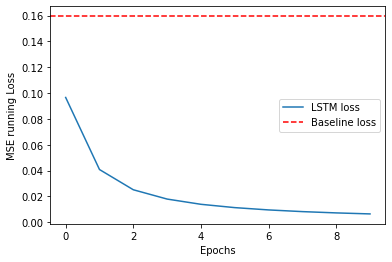

In [7]:
# Define hyperparameters and generate dataset
hidden_sizes = [8]
n_samples = 5000
n_epochs=10
datas = [generate_sample() for _ in range(n_samples)]      # datas is a LIST of tuples


# Split dataset into train and validation sets 
train_size = int(0.8 * len(datas))
val_size = len(datas) - train_size
train_datas, val_datas = random_split(datas, [train_size, val_size], generator=torch.Generator().manual_seed(42))

for hidden_size in hidden_sizes:
    # Instantiate model and optimizer
    LSTMnet_ = LSTMnet(input_size, hidden_size, output_size)
    LSTM_loss_list, baseline_loss = LSTMnet_.train(LSTMnet_, train_datas, n_epochs)
    

### Testing for LSTM

In [8]:
LSTM_cumulative_loss = 0
with torch.no_grad():
     for data in val_datas:

        # Get inputs and labels
        inputs, labels = data

        # Forward + backward prop using the loss defined + optimize using the optimiser defined 
        y_pred = LSTMnet_.forward(inputs)
        criterion = nn.MSELoss()
        loss = criterion(y_pred, torch.tensor([labels]).unsqueeze(1).float())


        # Update running loss
        LSTM_cumulative_loss += loss.item()


LSTM_cumulative_loss = LSTM_cumulative_loss/(len(datas))
print(f" Test_loss for LSTM {LSTM_cumulative_loss}. ")

 Test_loss for LSTM 0.011503463549981168. 


### Defining class for GRU(Gated Recurrent Unit)

In [9]:
class GRUnet(nn.Module):
    def __init__(self, ip_size, h_size, op_size):
        super().__init__()
        self.ip_size = ip_size
        self.h_size = h_size
        self.op_size = op_size
        
        # (Xavier weigth initialisation) 
         # Rest and update gate weights, hidden state weights
        self.W_rh = nn.Parameter(torch.empty(h_size, h_size), requires_grad=True) 
        self.W_rx = nn.Parameter(torch.empty(h_size, ip_size), requires_grad=True) 
        self.W_zh = nn.Parameter(torch.empty(h_size, h_size), requires_grad=True) 
        self.W_zx = nn.Parameter(torch.empty(h_size, ip_size), requires_grad=True) 
        self.W_hh = nn.Parameter(torch.empty(h_size, h_size), requires_grad=True) 
        self.W_hx = nn.Parameter(torch.empty(h_size, ip_size), requires_grad=True) 
        nn.init.xavier_uniform_(self.W_rh)
        nn.init.xavier_uniform_(self.W_rx)
        nn.init.xavier_uniform_(self.W_zh)
        nn.init.xavier_uniform_(self.W_zx)
        nn.init.xavier_uniform_(self.W_hh)
        nn.init.xavier_uniform_(self.W_hx)

        
        # Rest and update gate biases
        self.b_r = nn.Parameter(torch.rand(h_size, 1), requires_grad=True)               
        self.b_z = nn.Parameter(torch.rand(h_size, 1), requires_grad=True)   
        self.b_h = nn.Parameter(torch.rand(h_size, 1), requires_grad=True)                             


        # Output layer weights and biases
        self.W_hy = nn.Parameter(torch.empty(op_size, h_size), requires_grad=True)  
        nn.init.xavier_uniform_(self.W_hy)        
        self.b_y = nn.Parameter(torch.zeros(op_size, 1), requires_grad=True)                
        
        # hidden state is initialised as zero vectors
        self.h_t = torch.zeros(h_size, 1)
    
    def forward(self, x):
        """ 
        x : numpy 2D array : 1st dimension b/w [0,1] and 2nd dimension having 1 in two of the places
        Returns:
            y : scalar value : predicted value.
        """        
        H = self.h_t
        
        for t in range(x.shape[0]):
            r_t = torch.sigmoid(torch.matmul(self.W_rx.data ,torch.Tensor(x[t]).unsqueeze(1)) + torch.matmul(self.W_rh.data, H) + self.b_r)
            z_t = torch.sigmoid(torch.matmul(self.W_zx.data ,torch.Tensor(x[t]).unsqueeze(1)) + torch.matmul(self.W_zh.data, H) + self.b_z)
            ht_hat = torch.tanh(torch.matmul(self.W_hx.data ,torch.Tensor(x[t]).unsqueeze(1)) + torch.matmul(self.W_hh.data, torch.mul(r_t, H)) + self.b_h)
            
            H = torch.mul(1 - z_t, H) + torch.mul(z_t, ht_hat)
            
        y = torch.relu(torch.matmul(self.W_hy.data, H) + self.b_y)
        
        return y
    
    def train(self, net, datas, n_epochs = 20):
        """ 
            Trains the network {net} for {n_epochs} epochs using the train data {datas} 
            net : A instantiated neural network class
            datas : Train data is a list of tuples where tuples are of the form ({2D array of variable length}, {label})
            n_epochs : Number of epochs to train for.
                                                                                                                        """
        # Define the optimiser and loss function
        optimizer = optim.SGD(net.parameters(), lr=0.05)
        criterion = nn.MSELoss()                         # (Loss fn = MSE)
        
        # Training loop
        baseline_loss = 0
        cumulative_loss_list = []
        for epoch in range(1, n_epochs + 1):
            cumulative_loss = 0
            for i, data in enumerate(datas, 0):
                
                # Get inputs and labels
                inputs, labels = data
                
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward + backward prop using the loss defined + optimize using the optimiser defined 
                y_pred = self.forward(inputs)
                loss = criterion(y_pred, torch.tensor([labels]).unsqueeze(1).float())
#               loss = (y_pred - torch.tensor([labels])) * (y_pred - torch.tensor([labels]))
                
                # Compute gradients using backward pass
                loss.backward()
                if epoch == 1:
                    baseline_loss += criterion(torch.tensor([[1]]), torch.tensor([labels]).unsqueeze(1).float())
                
                # Update the parameters using the gradients and Adam optimiser
                optimizer.step()

                # Update running loss
                cumulative_loss += loss.detach()

            
            cumulative_loss = cumulative_loss/(epoch*len(datas))
            cumulative_loss_list.append(cumulative_loss)
            print(f"Epoch {epoch}, Epoch_loss {cumulative_loss}. ")
        
        plt.plot(cumulative_loss_list, label='LSTM loss')
        plt.xlabel('Epochs')
        plt.ylabel('MSE running Loss')
        plt.axhline(y=baseline_loss/len(datas), color='r', ls='--', label='Baseline loss')
        plt.legend()
        print(f"Baseline loss {baseline_loss/len(datas)}")
        
        return cumulative_loss_list


### Training for GRU

Epoch 1, Epoch_loss 0.15850573778152466. 
Epoch 2, Epoch_loss 0.0710182934999466. 
Epoch 3, Epoch_loss 0.04459968954324722. 
Epoch 4, Epoch_loss 0.03151316195726395. 
Epoch 5, Epoch_loss 0.02377520501613617. 
Epoch 6, Epoch_loss 0.019233981147408485. 
Epoch 7, Epoch_loss 0.016295047476887703. 
Epoch 8, Epoch_loss 0.014168204739689827. 
Epoch 9, Epoch_loss 0.01254083402454853. 
Epoch 10, Epoch_loss 0.011252373456954956. 
Baseline loss 0.16709889471530914


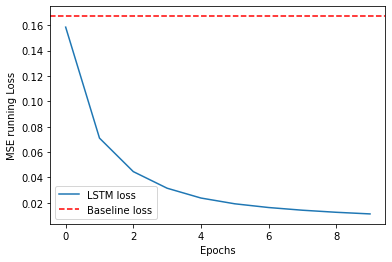

In [10]:
# Define hyperparameters and generate dataset 
hidden_sizes = [6]
n_samples = 10000
n_epochs=10
datas = [generate_sample() for _ in range(n_samples)]      # datas is a LIST of tuples


# Split dataset into train and validation sets 
train_size = int(0.8 * len(datas))
val_size = len(datas) - train_size
train_datas, val_datas = random_split(datas, [train_size, val_size], generator=torch.Generator().manual_seed(42))

for hidden_size in hidden_sizes:
    # Instantiate model and optimizer
    GRUnet_ = GRUnet(input_size, hidden_size, output_size)
    GRU_loss_list = GRUnet_.train(GRUnet_, train_datas, n_epochs)
    

### Testing for GRU

In [19]:
GRU_cumulative_loss = 0
baseline_test_loss = 0
with torch.no_grad():
     for data in val_datas:

        # Get inputs and labels
        inputs, labels = data

        # Forward + backward prop using the loss defined + optimize using the optimiser defined 
        y_pred = GRUnet_.forward(inputs)
        criterion = nn.MSELoss()
        loss = criterion(y_pred, torch.tensor([labels]).unsqueeze(1).float())
        baseline_test_loss += criterion(torch.tensor([[1]]), torch.tensor([labels]).unsqueeze(1).float())/len(val_datas)
    
        # Update running loss
        GRU_cumulative_loss += loss.item()


GRU_cumulative_loss = GRU_cumulative_loss/(len(datas))
print(f" Test_loss for GRU :{GRU_cumulative_loss}. ")
print(f" Baeline Test loss :{baseline_test_loss}. ")

 Test_loss for GRU :0.021719950498234556. 
 Baeline Test loss :0.1611330658197403. 


### Plot of Running Loss while Training 

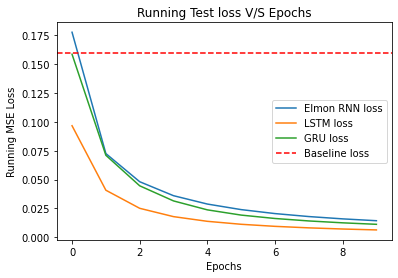

In [20]:
plt.plot(RNN_loss_list, label='Elmon RNN loss')
plt.plot(LSTM_loss_list, label='LSTM loss')
plt.plot(GRU_loss_list, label='GRU loss')
plt.title('Running Test loss V/S Epochs')
plt.xlabel('Epochs')
plt.ylabel('Running MSE Loss')
plt.axhline(y=baseline_loss, color='r', ls='--', label='Baseline loss')
plt.legend()
plt.show()

## Test Loss comparison by plots 

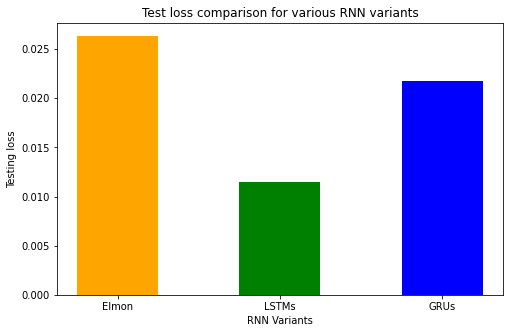

In [21]:
RNN_variants = ['Elmon', 'LSTMs', 'GRUs']
test_loss = [Rnn_cumulative_loss, LSTM_cumulative_loss, GRU_cumulative_loss]
  
fig = plt.figure(figsize = (8, 5))
 
# creating the bar plot
plt.bar(RNN_variants, test_loss, color =['orange', 'green', 'blue'],
        width = 0.5)
 
plt.xlabel("RNN Variants")
plt.ylabel("Testing loss")
plt.title("Test loss comparison for various RNN variants")
plt.show()

## Explained Variance comparison by plots

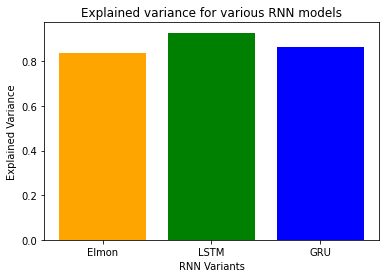

In [22]:
elmon_exp_var = 1 - Rnn_cumulative_loss/baseline_test_loss
lstm_exp_var = 1 - LSTM_cumulative_loss/baseline_test_loss
gru_exp_var = 1 - GRU_cumulative_loss/baseline_test_loss


plt.bar(['Elmon', 'LSTM', 'GRU'], [elmon_exp_var, lstm_exp_var, gru_exp_var], color =['orange', 'green', 'blue'])
plt.xlabel("RNN Variants")
plt.ylabel("Explained Variance")
plt.title('Explained variance for various RNN models')
plt.show()
